c:\Users\Francesco\anaconda3\envs\env\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


DEM opened successfully
DEM size: 3601 x 3601
(-80.00013888888888, 0.0002777777777777778, 0.0, -0.9998611111111111, 0.0, -0.0002777777777777778)
DEM NoData value: -32767.0
DEM min value: -57
DEM max value: 4143


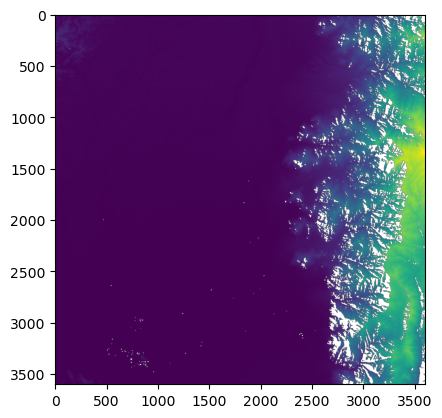

In [2]:
# READING GEOTIFF IMAGES

from osgeo import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ee
import geemap

# Read a SRTM DEM on Bolivar Province (Ecuador)
dem_path = r"C:\Users\Francesco\Python\earthlab\data\Ecuador\DEM\s02_w080_1arc_v3.tif"
dem_img = gdal.Open(dem_path)

if dem_img is None:
    print("The DEM hasn't been read")
else:
    print("DEM opened successfully")
    print('DEM size:', dem_img.RasterXSize, 'x', dem_img.RasterYSize)

# Get the geotransform
dem_gt = dem_img.GetGeoTransform()
print(dem_gt)

# Get the band
dem_band = dem_img.GetRasterBand(1)

# Transform the raster in an array (numpy)
dem_cols = dem_img.RasterXSize
dem_rows = dem_img.RasterYSize
dem_np = dem_band.ReadAsArray(0, 0, dem_cols, dem_rows)

# Mask NoData
dem_nodata_value = dem_band.GetNoDataValue()
print('DEM NoData value:', dem_nodata_value)
dem_np = np.ma.masked_equal(dem_np, dem_nodata_value)

# Get min and max values in the array
print('DEM min value:', np.min(dem_np))
print('DEM max value:', np.max(dem_np))

# Show the DEM
plt.imshow(dem_np, vmin=0, vmax=4143)
plt.show()

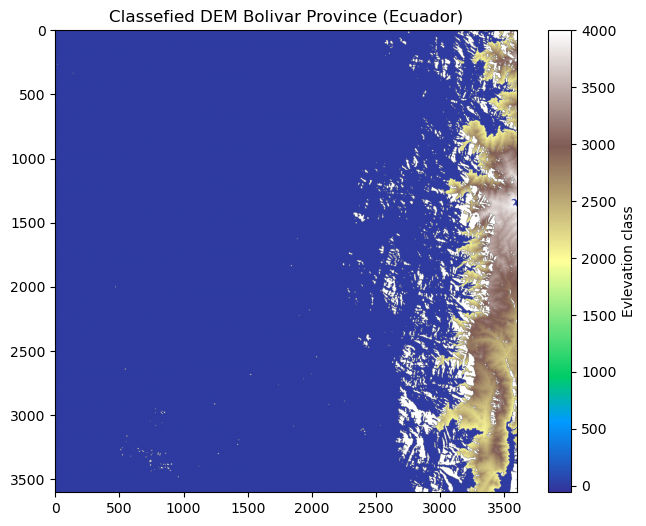

In [3]:
# Show the DEM classes <1000, 1000-2000, 3000-4000, >4000
dem_np_cl = dem_np.copy()

dem_np_cl[(dem_np_cl>0) & (dem_np_cl<=1000)] = 1
dem_np_cl[(dem_np_cl>1000) & (dem_np_cl<=2000)] = 2
dem_np_cl[(dem_np_cl>2000) & (dem_np_cl<=2000)] = 3
dem_np_cl[(dem_np_cl>4000)] = 4

plt.figure(figsize=(8, 6))
plt.imshow(dem_np_cl, cmap='terrain')
plt.colorbar(label='Evlevation class')
plt.title('Classefied DEM Bolivar Province (Ecuador)')
plt.show()

In [4]:
# Calculate the DEM bounding box
xmin = dem_gt[0]
ymin = dem_gt[3]
xmax = dem_gt[0] + dem_cols*dem_gt[1]
ymax = dem_gt[3] + dem_rows*dem_gt[5]
print("Bounding Box: ", f"xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

# MODIS NDVI Time Series

# Use Google Earth Engine
ee.Authenticate()
ee.Initialize()

aoi = ee.Geometry.Rectangle([xmin, ymin, xmax, ymax])

Bounding Box:  xmin: -80.00013888888888, ymin: -0.9998611111111111, xmax: -78.9998611111111, ymax: -2.000138888888889


In [5]:
# Get the modis images for the dry season in the aoi
modis = ee.ImageCollection('MODIS/061/MOD09GA').filterBounds(aoi).filterDate('2025-05-01', '2025-10-01')

# Create and add the NDVI band
def add_ndvi(image):
    ndvi = image.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename('NDVI')
    return image.addBands(ndvi)

modis_ndvi = modis.map(add_ndvi)
modis_first = modis_ndvi.first()
print(modis_first.bandNames().getInfo())

['num_observations_1km', 'state_1km', 'SensorZenith', 'SensorAzimuth', 'Range', 'SolarZenith', 'SolarAzimuth', 'gflags', 'orbit_pnt', 'granule_pnt', 'num_observations_500m', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07', 'QC_500m', 'obscov_500m', 'iobs_res', 'q_scan', 'NDVI']


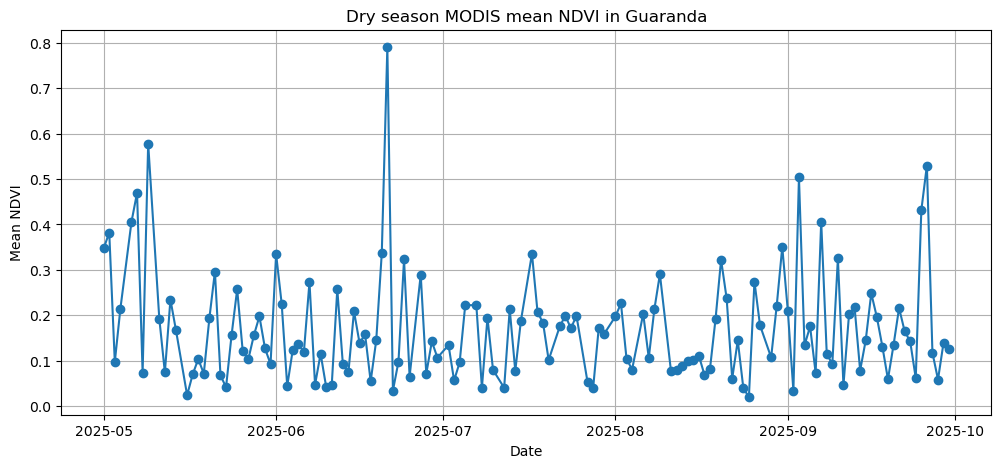

In [ ]:
# Get the mean NDVI for each image
def get_mean_ndvi(image):
    mean_dict = image.select('NDVI').reduceRegion(reducer=ee.Reducer.mean(),
                                                  geometry=aoi,
                                                  scale=500,
                                                  maxPixels=1e13)
    return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd'),
                             'NDVI': mean_dict.get('NDVI')})

ndvi_features = modis_ndvi.map(get_mean_ndvi)
ndvi_fc = ee.FeatureCollection(ndvi_features)

# Convert into Pandas DataFrame
ndvi_list = ndvi_fc.getInfo()['features']
data = [(f['properties'].get('date'), f['properties'].get('NDVI')) 
        for f in ndvi_list
        if f['properties'].get('NDVI') is not None]
ndvi_df = pd.DataFrame(data, columns=['date', 'NDVI'])
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df['NDVI'] = pd.to_numeric(ndvi_df['NDVI'])
# remove missing ndvi values
ndvi_df = ndvi_df.dropna()

# Plot NDVI time series
plt.figure(figsize=(12, 5))
plt.plot(ndvi_df['date'], ndvi_df['NDVI'], marker='o', linestyle='-')
plt.title('Dry season MODIS mean NDVI in Guaranda')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.grid(True)
plt.show()
